# Functions
## Import national data

In [14]:
using CSV, DataFrames, Plots, StatsPlots, Contour,
Dates, GLM, Pipe, Underscores,
Statistics, StatsBase, RollingFunctions, Optim;
using Plots.PlotMeasures;
######### set global values
date_of_first_obs = Date("2020-05-01"); # cut-off date
windowsize = 7; # window size for aggregating data into windowsize-ly data
sub_sample_size = 90;  # sub-sample study size 
Nstar = 5800000; # N*, to get adjusted cases numbers
nstar = log(Nstar);
# common initial values
ω0 = 0;
ϕ0 = 1;
α0 = 0.05;
ϕ_range = collect(0 : 0.005 : 1);
α_range = collect(0 : 0.005 : 1);
ϕϕ_range = repeat(ϕ_range, inner=[size(α_range,1)]); # for vectorize
αα_range = repeat(α_range, outer=[size(ϕ_range,1)]);
Holidays2020 = [Date(2020,04,09); # through April 13
            Date(2020,05,08); Date(2020,05,21);
            Date(2020,06,01); Date(2020,06,05);
            Date(2020,12,24); Date(2020,12,25); Date(2020,12,26)];
Holidays2021 = [Date(2021,01,01); 
            Date(2021,04,01); # through April 5
            Date(2021,04,30); Date(2021,05,13);
            Date(2021,05,23); Date(2021,05,24);
            Date(2021,06,05);
            Date(2021,12,24); Date(2021,12,25); Date(2021,12,26)];
Holidays2022 = [Date(2022,01,01)];
AlphaVariant = Date(2020,12,18);
DeltaVariant = Date(2021,04,04);
OmicronVariant = Date(2021,11,24);
Variants = [AlphaVariant, DeltaVariant, OmicronVariant];
######### import and clean data, 
### notes: groupby, combine, unstack, xticks labels
national = @pipe CSV.File("Test_pos_over_time.csv", 
                        footerskip=2, 
                        select = [1, 2, 6], 
                        typemap = Dict(Float64 => String),
                        dateformat="yyyy-mm-dd") |> 
        DataFrame |> 
        transform!(_, :Date, 
                  :Tested => (x -> parse.(Int, replace.(x, "." => ""))) => :Nt, 
                  :NewPositive => (x -> parse.(Int, replace.(x, "." => ""))) => :Ct) |>
        transform(_, :Nt => (x -> log.(x)) => :nt,
                    :Ct => (x -> log.(x)) => :ct,
                    [:Nt, :Ct] => ((x, y) -> y ./ x) => :PosRate) |>
        transform(_, :nt => (x -> replace!(x, -Inf => 0)) => :nt,
                     :ct => (x -> replace!(x, -Inf => 0)) => :ct,
                     :PosRate => (x -> replace!(x, NaN => 0)) => :PosRate) |>
        transform(_, :nt => (x -> x - lag(x)) => :Dnt,
                     :ct => (x -> x - lag(x)) => :Dct,
                     :Date => (x -> Dates.month.(x)) => :Month,
                     :Date => (x -> Dates.year.(x)) => :Year,
                     :Date => (x -> Dates.dayofweek.(x)) => :Day)

national_daily = @pipe national |>
                transform(_, :nt => (x -> lag(x)) => :nt_lag) |> 
                subset(_, :Date => ByRow(D -> D >= date_of_first_obs)); # drop data before 2020-07-01 ;

national_weekly = @pipe national |>
        select(_, :Date,
                  :Month,
                  :Year,
                  :Day,
                  :Nt => (v -> runmean(v, windowsize) * windowsize) => :Nt, 
                  :Ct => (v -> runmean(v, windowsize) * windowsize) => :Ct)  |>
        delete!(_, 1: (windowsize - 1)) |>
        transform(_, :Nt => (x -> log.(x)) => :nt,
                     :Ct => (x -> log.(x)) => :ct,
                     [:Nt, :Ct] => ((x, y) -> y ./ x) => :PosRate) |>
        transform(_, :nt => (x -> replace!(x, -Inf => 0)) => :nt,
                     :ct => (x -> replace!(x, -Inf => 0)) => :ct,
                     :PosRate => (x -> replace!(x, NaN => 0)) => :PosRate) |>
        transform(_, :nt => (x -> x - lag(x)) => :Dnt,
                     :ct => (x -> x - lag(x)) => :Dct,
                     :nt => (x -> lag(x)) => :nt_lag) |>
        subset(_, :Date => ByRow(D -> D >= date_of_first_obs)); # drop data before 2020-07-01 ;

national_7dd = @pipe national |>
        select(_, :Date,
                  :Month,
                  :Year,
                  :Day,
                  :Nt,
                  :Ct,
                  :nt,
                  :ct,
                  :nt => (x -> x - lag(x, 7)) => :Dnt,
                  :ct => (x -> x - lag(x, 7)) => :Dct,
                  :nt => (x -> lag(x, 7)) => :nt_lag) |>
        subset(_, :Date => ByRow(D -> D >= date_of_first_obs)); # drop data before 2020-07-01 ;

βasθ(θ) = 1 / (1 + exp(-θ));


## Import muni data

In [15]:
# Remove Municipalities with too few Nt (< 100 on average)
drop_cities = ["Christiansø", "Ærø", "Fanø", "Samsø", "Læsø", "NA"]

muni_Ct = @pipe CSV.File("Municipality_cases_time_series.csv", footerskip=1) |>
DataFrame |>
rename!(_, :SampleDate => :Date) |>
select(_, Not(drop_cities));
muni_Nt = @pipe CSV.File("Municipality_tested_persons_time_series.csv", footerskip=1) |> 
DataFrame |>
rename!(_, :PrDate_adjusted => :Date) |>
select(_, Not(drop_cities));
muni_daily_level = @pipe innerjoin(muni_Ct, muni_Nt, on = :Date, makeunique=true);
## Notes: The orders of the columns in the two files are different.

# create daily Dnt and Dct data for model
muni_ct_nt = @pipe muni_daily_level |>
transform(_, names(_, Not(:Date)) .=> (x -> log.(x)); renamecols=false);
for col in eachcol(muni_ct_nt)
    replace!(col, -Inf => 0)  # When initial numbers are 0, replace log of it to be 0 instead of -inf.
end
muni_daily = @pipe muni_ct_nt |> 
transform(_, names(_, Not(:Date)) .=> (x -> x - lag(x)); renamecols=false)|>
subset(_, :Date => ByRow(D -> D >= date_of_first_obs));

# create weekly Dnt and Dct data for model
muni_weekly_level = mapcols!(v -> runmean(v, windowsize) * windowsize, muni_daily_level[:, Not(:Date)]);
insertcols!(muni_weekly_level, 1, :Date => muni_daily_level.Date);
delete!(muni_weekly_level, 1: (windowsize - 1));
df2 = @pipe muni_weekly_level |>
transform(_, names(_, Not(:Date)) .=> (x -> log.(x)); renamecols=false);
for col in eachcol(df2)
    replace!(col, -Inf => 0)  # When initial numbers are 0, replace log of it to be 0 instead of -inf.
end
muni_weekly = @pipe df2 |> 
transform(_, names(_, Not(:Date)) .=> (x -> x - lag(x)); renamecols=false)|>
subset(_, :Date => ByRow(D -> D >= date_of_first_obs));

# create weekday D7nt and D7ct data for model
muni_7dd = @pipe muni_ct_nt |> 
transform(_, names(_, Not(:Date)) .=> (x -> x - lag(x, 7)); renamecols=false)|>
subset(_, :Date => ByRow(D -> D >= date_of_first_obs));

## Simple OLS

In [16]:
# each beta is a cross-sectional estimate
function panel_time_varying_beta(data)
    Results = DataFrame(Date = [], β = [], std = [])
    T = nrow(data)
    for i in 1:T
        x = Float64[];
        for j in 2:Int((ncol(data)+1)/2)
            city_name = names(data)[j]  
            push!(x, data[i, string(city_name, "_1")]) 
        end
        OLS_data = DataFrame(x = x, 
                             y = collect(data[i, 2: Int( (ncol(data)+1)/2) ]));
        OLS = lm(@formula(y ~ x), OLS_data)
        coef_w_time = @pipe round.(coef(OLS)[2], digits = 4) |> 
        vcat(_, round.(stderror(OLS)[2], digits = 4)) |>
        vcat([data.Date[i]], _)
        push!(Results, coef_w_time);
    end
    return(Results)
end

function panel_OLS_noCI(OLS_results, data_type)
    @df OLS_results plot(:Date, :β, title = data_type, xlabel = "Date", ylabel = "β", label = :none)
    hline!([0], color = :red, label=:none)
    hline!([1], color = :red, label=:none)
end

function panel_OLS_CI(OLS_results, data_type)
    @df OLS_results plot(:Date, :β, grid = false, ribbon = :std,  title = data_type, xlabel = "Date", ylabel = "β", label = :none)
    hline!([0], color = :red, label=:none)
    hline!([1], color = :red, label=:none)
end

# run OLS for approach 1
muni_daily_OLS = panel_time_varying_beta(muni_daily);
muni_weekly_OLS = panel_time_varying_beta(muni_weekly);
muni_7dd_OLS = panel_time_varying_beta(muni_7dd);
muni_daily_noCI = panel_OLS_noCI(muni_daily_OLS, "Daily");
muni_daily_CI = panel_OLS_CI(muni_daily_OLS, "Daily");
muni_weekly_noCI = panel_OLS_noCI(muni_weekly_OLS, "Weekly");
muni_weekly_CI = panel_OLS_CI(muni_weekly_OLS, "Weekly");
muni_7dd_noCI = panel_OLS_noCI(muni_7dd_OLS, "7DD");
muni_7dd_CI = panel_OLS_CI(muni_7dd_OLS, "7DD");
    

## Var-cov of positive rate

In [17]:
# var-cov for muni
using LinearAlgebra;
muni_daily_PosRatio = DataFrame(); 
for i in 1 : Int((ncol(muni_daily_level)-1)/2)
    Ct = muni_daily_level[:, i+1];
    city_name = names(muni_daily_level)[i + 1];
    Nt = muni_daily_level[:, string(city_name, "_1")];
    ratio = Ct ./ Nt;
    muni_daily_PosRatio[!, city_name] = ratio;
end
insertcols!(muni_daily_PosRatio, 1, :Date => muni_daily_level.Date);
for col in eachcol(muni_daily_PosRatio)
    replace!(col, NaN => 0, Inf => 0);  # When Nt are 0, replace the ratio to be 0 instead of NaN and Inf.
end
subset!(muni_daily_PosRatio, :Date => ByRow(D -> D >= date_of_first_obs));
X = Matrix(mapcols!(v -> v .- mean(v), muni_daily_PosRatio[:, Not(:Date)]));
muni_var_cov = transpose(X) * X;
Dinv = inv(diagm(sqrt.(diag(muni_var_cov))));
muni_corr_mat = Dinv * muni_var_cov * Dinv;

muni_corr_vec = [muni_corr_mat[i, j] for i = 1:size(muni_corr_mat, 1), j = 1:size(muni_corr_mat, 2) if i > j];

# plot of observed positive rates
observedPos = plot(Matrix(muni_daily_PosRatio)[:,1], Matrix(muni_daily_PosRatio[:, Not(:Date)]), 
    label = :none, color = :blue, alpha = 0.02, ylim = (0, 0.5), 
    ylabel = "Observed positive rate", xlabel = "Date",
    xticks = collect(muni_daily_PosRatio.Date[1]:Month(4):muni_daily_PosRatio.Date[nrow(muni_daily_PosRatio)]))
    plot!(muni_daily_PosRatio.Date, national_daily.PosRate, color = :red, label = :none); 
CorrPos = density(muni_corr_vec, label = :none, ylabel = "Density", title = "Correlation between positive rates");

## Model 1 restricted

In [18]:
# Muni score model 1 - compared to national
# working here, marker
function recoverTheta_muni1(par, city_name, muni_data, national_data)
    y = muni_data[:, city_name] - national_data.Dct
    Dn_it = muni_data[:, string(city_name, "_1")]
    Dn_Nt = national_data.Dnt
    T = nrow(muni_data);
    ω1 = par[1]; 
    ϕ1 = par[2];
    α1 = par[3]; 
    ω2 = par[4]; 
    ϕ2 = par[5];
    α2 = par[6]; 
    σ = par[7];
    θ1_0 = par[8];
    θ2_0 = par[9];
    θ1 = [];
    θ2 = [];
    push!(θ1, θ1_0)
    push!(θ2, θ2_0)
    for i in 1:(T-1)
        v1 = ω1 + 
        ϕ1 * θ1[i] + 
        α1 * (1 / σ) * sign(Dn_it[i]) * ( y[i] - Dn_it[i] * βasθ(θ1[i]) + Dn_Nt[i] * βasθ(θ2[i])) 

        v2 = ω2 + 
        ϕ2 * θ2[i] + 
        α2 * (1 / σ) * sign(Dn_Nt[i]) * ( y[i] - Dn_it[i] * βasθ(θ1[i]) + Dn_Nt[i] * βasθ(θ2[i])) 

        push!(θ1, v1)
        push!(θ2, v2)
    end
    return θ1, θ2
end

function Ut_muni1(par, city_name, muni_data, national_data)
    y = muni_data[:, city_name] - national_data.Dct
    Dn_it = muni_data[:, string(city_name, "_1")]
    Dn_Nt = national_data.Dnt
    θi, θN = recoverTheta_muni1(par, city_name, muni_data, national_data);
    Ut = y .- Dn_it .* βasθ.(θi) + Dn_Nt .* βasθ.(θN)
end

function logL_muni1(par, city_name, muni_data, national_data)
    T = nrow(muni_data);
    σ = par[7];
    Ut = Ut_muni1(par, city_name, muni_data, national_data)
    ll = - T * log(σ^2) / 2 - sum(Ut .^ 2)/(2 * σ^2)  
    return(ll)
end

function OLS_produce_initial_muni1(city_name, muni_data, national_data)
    T = nrow(muni_data)
    y = muni_data[:, city_name] - national_data.Dct
    X = [muni_data[:, string(city_name, "_1")] national_data.Dnt]
    OLS0 = lm(X, y);
    yHat = predict(OLS0);
    σ0 = std(y - yHat); # use OLS results as initial values for sigma and theta0
    βi0 = ifelse(coef(OLS0)[1] <= 0, 0.0001, ifelse(coef(OLS0)[1] >= 1, 0.9999, coef(OLS0)[1]));
    βN0 = ifelse(coef(OLS0)[2] <= 0, 0.0001, ifelse(coef(OLS0)[2] >= 1, 0.9999, coef(OLS0)[2]));
    θi0 = log(βi0 / (1 - βi0));
    θN0 = log(βN0 / (1 - βN0));
    return(σ0, θi0, θN0)
end

function find_σ_θ_ini_muni1(ω0, ϕ0, α0, city_name, muni_data, national_data)
    findIni(a, b1, b2) = logL_muni1([ω0, ϕ0, α0, ω0, ϕ0, α0, a, b1, b2], city_name, muni_data, national_data); # a = σ; b1 = θ1; b2 = θ2; define a function in sigma and theta0
    obj0 = para -> -findIni(para[1], para[2], para[3])
    σ0, θi0, θN0 = OLS_produce_initial_muni1(city_name, muni_data, national_data)
    Optim0 = optimize(obj0, [σ0, θi0, θN0]) # optimize sigma and theta0 based on input values of omega, phi, sigma
    new_initial = Optim.minimizer(Optim0);
    σ = new_initial[1]
    θi = new_initial[2] 
    θN = new_initial[3]
    return(σ, θi, θN)
end
#####################
function manual_optim_αOnly_muni1(ω0, ϕ0, α0, city_name, muni_data, national_data, αα_range1, αα_range2)
    σ, θi, θN = find_σ_θ_ini_muni1(ω0, ϕ0, α0, city_name, muni_data, national_data);
    f(α1, α2) = logL_muni1([ω0, ϕ0, α1, ω0, ϕ0, α2, σ, θi, θN], city_name, muni_data, national_data);;
    ll_range = f.(αα_range1, αα_range2);
    max_ll, max_index = findmax(ll_range);
    max_α1 = αα_range1[max_index];
    max_α2 = αα_range2[max_index];
    Optimized_Parameters = [ω0, ϕ0, max_α1, ω0, ϕ0, max_α2, σ, θi, θN];
    return(Optimized_Parameters, max_ll, f)
end

function muni1_res_generator(muni_data, national_data)
    muni1_res_coef = DataFrame(City = String[], 
    αi = String[], αN = String[], σ = String[], logL = String[]);
    muni1_βi = DataFrame();
    muni1_βN = DataFrame();
    for city_name in names(muni_data)[2: Int((ncol(muni_data)+1)/2)] 
        Optimized_para, max_ll, _ = manual_optim_αOnly_muni1(ω0, ϕ0, α0, city_name, muni_data, national_data, αα_range1, αα_range2)
        θ1, θ2 = recoverTheta_muni1(Optimized_para, city_name, muni_data, national_data)
        αi = Optimized_para[3]
        αN = Optimized_para[6]
        σ = Optimized_para[7]
        coef_w_name = @pipe round.([αi, αN, σ, max_ll], digits = 4) |> string.(_) |> append!([city_name],  _);
        push!(muni1_res_coef, coef_w_name);
        muni1_βi[!, city_name] = βasθ.(θ1);
        muni1_βN[!, city_name] = βasθ.(θ2);
    end
    #insertcols!(muni1_res_coef, 1, :Date => muni_data.Date);
    return(muni1_res_coef, muni1_βi, muni1_βN)
end

# just finished restricted version

muni1_res_generator (generic function with 1 method)

In [19]:

ω0, ϕ0, α0 = 0, 1, 0.1;
αα_range1 = repeat(α_range, inner=[size(α_range,1)]); # for vectorize
αα_range2 = repeat(α_range, outer=[size(α_range,1)]);

In [25]:
#muni1_res_coef_daily, muni1_βi_daily, muni1_βN_daily = muni1_res_generator(muni_daily, national_daily);
CSV.write("muni1_res_coef_daily", muni1_res_coef_daily)
CSV.write("muni1_betai_daily", muni1_βi_daily)
CSV.write("muni1_betaN_daily", muni1_βN_daily)

"muni1_betaN_daily"

In [26]:
#muni1_res_coef_weekly, muni1_βi_weekly, muni1_βN_weekly = muni1_res_generator(muni_weekly, national_weekly);
CSV.write("muni1_res_coef_weekly", muni1_res_coef_weekly)
CSV.write("muni1_betai_weekly", muni1_βi_weekly)
CSV.write("muni1_betaN_weekly", muni1_βN_weekly)

"muni1_betaN_weekly"

In [27]:
#muni1_res_coef_7dd, muni1_βi_7dd, muni1_βN_7dd = muni1_res_generator(muni_7dd, national_7dd);
CSV.write("muni1_res_coef_7dd", muni1_res_coef_7dd)
CSV.write("muni1_betai_7dd", muni1_βi_7dd)
CSV.write("muni1_betaN_7dd", muni1_βN_7dd)

"muni1_betaN_7dd"

In [ ]:
b1 = plot(muni_daily.Date, Matrix(muni1_βi_daily), 
    color = :blue, alpha = 0.3, label = :none,
    title = "Daily βi",
    xticks = collect(muni_daily.Date[1]:Month(4):muni_daily.Date[nrow(muni_daily)]));
a1 = histogram(parse.(Float64, muni1_res_coef_daily.αi), 
    bins = 0:0.01:1, title = "Daily αi", label = :none);

## Model 2

In [ ]:
nstar_Aarhus = log(349983)
nstar_Aalborg = log(217094)
nstar_Odense = log(204895)
nstar_Copenhagen = log(1346000)


# Text

## Model 1 structure
With locally constant assumption,
$i$ presents a municipality,
$$
\Delta c_{i, t} = 
\beta_{i, t} \Delta n_{i, t} + 
\Delta \log(\pi^*_{i, t}) +
U_{i, t}
$$

$N$ represents the national aggregated,
$$
\Delta c_{N, t} = 
\beta_{N, t} \Delta n_{N, t} + 
\Delta \log(\pi^*_{N, t}) +
U_{N, t}
$$

Substract national from each municipality,
$$
\Delta c_{i, t} - \Delta c_{N, t} = 
\beta_{i, t} \Delta n_{i, t} - 
\beta_{N, t} \Delta n_{N, t} +
\Delta \log(\pi^*_{i, t}) - \Delta log(\pi^*_{N, t}) +
U_{i, t} - 
U_{N, t}
$$
To model $\beta_{i, t}$ and $\beta_{N, t}$, need two score equations:
$$
\psi(\theta_{i, t}) =
\frac{\frac{\partial \ell}{\partial \theta_{i, t}}}{\sqrt{- \frac{\partial^2 \ell}{\partial \theta_{i, t}^2}}}
=
\frac{1}{\sigma} \text{sign}(\Delta n_{i, t}) 
\left(\Delta c_{i, t} - \Delta c_{N, t} -
\frac{\Delta n_{i, t}}{1 + \exp(-\theta_{i, t})} +
\frac{\Delta n_{N, t}}{1 + \exp(-\theta_{N, t})} \right)
$$

$$
\psi(\theta_{N, t}) =
\frac{\frac{\partial \ell}{\partial \theta_{N, t}}}{\sqrt{- \frac{\partial^2 \ell}{\partial \theta_{N, t}^2}}}
=
\frac{1}{\sigma} \text{sign}(\Delta n_{N, t}) 
\left(\Delta c_{i, t} - \Delta c_{N, t} -
\frac{\Delta n_{i, t}}{1 + \exp(-\theta_{i, t})} +
\frac{\Delta n_{N, t}}{1 + \exp(-\theta_{N, t})} \right)
$$

The new score model is:
$$
\theta_{i, t+1} = \omega_i + \phi_i \theta_{i, t} + \alpha_i \psi(\theta_{i, t})
$$

$$
\theta_{N, t+1} = \omega_N + \phi_N \theta_{N, t} + \alpha_N \psi(\theta_{N, t})
$$

## Model 2 structure
$$
c_{i, t} - c_{j, t} =
\beta_{i, t} n_{i, t} - 
\beta_{j, t} n_{j, t} +
(1 - \beta_{i, t}) n^*_{i} - 
(1 - \beta_{j, t}) n^*_{j} +
\log (\pi_{i, t}^*) -
\log (\pi_{j, t}^*) +
U_{t}
$$

To model $\beta_{i, t}$ and $\beta_{j, t}$, need two score equations:
$$
\begin{aligned}
\psi(\theta_{j, t}) & =
\psi(\theta_{i, t}) =
\frac{\frac{\partial \ell}{\partial \theta_{i, t}}}{\sqrt{- \frac{\partial^2 \ell}{\partial \theta_{i, t}^2}}}
= \\ &
- \frac{1}{\sigma}
\left(
c_{i, t} - c_{j, t} -
\beta_{i, t} n_{i, t} +
\beta_{j, t} n_{j, t} -
(1 - \beta_{i, t}) n^*_{i} + 
(1 - \beta_{j, t}) n^*_{j}
 \right)
 \end{aligned}
$$

# Results

## Positive rates

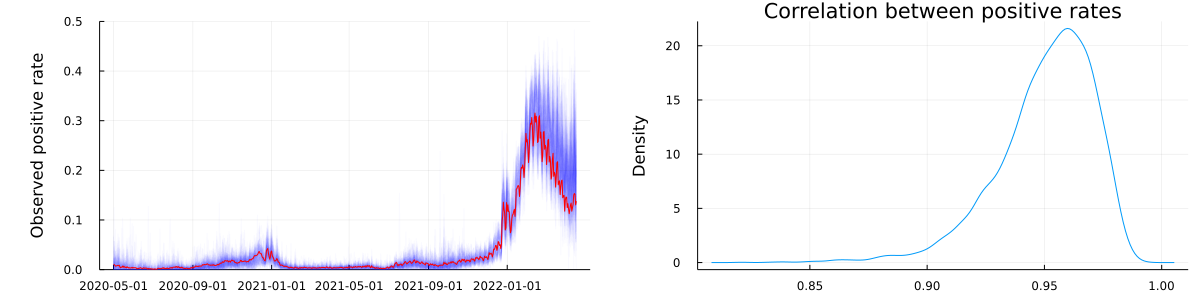

In [23]:
#Plot all 94 cities, observed positive rates.
plot(observedPos, CorrPos, 
    layout = (1, 2), size = (1200, 300), left_margin = 50px)

## Simple OLS

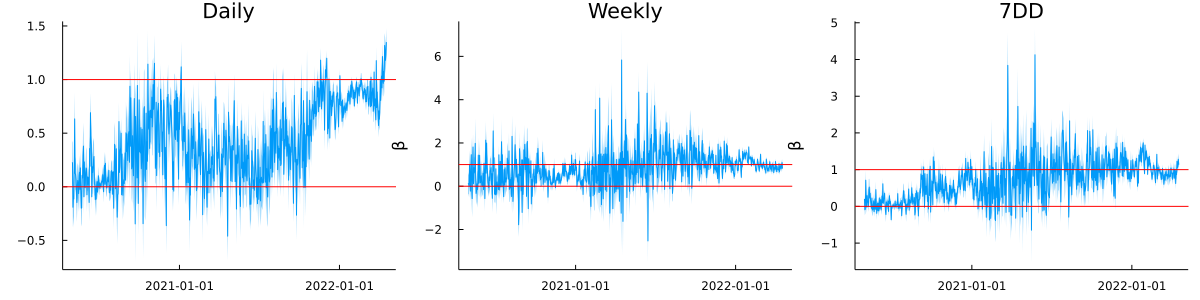

In [24]:
# Each \beta_t is a cross sectional estimate with 94 observations.
plot(muni_daily_CI, muni_weekly_CI, muni_7dd_CI,
    layout = (1, 3), size = (1200, 300))
#png("5-muni-ols")

## Model 1 restricted

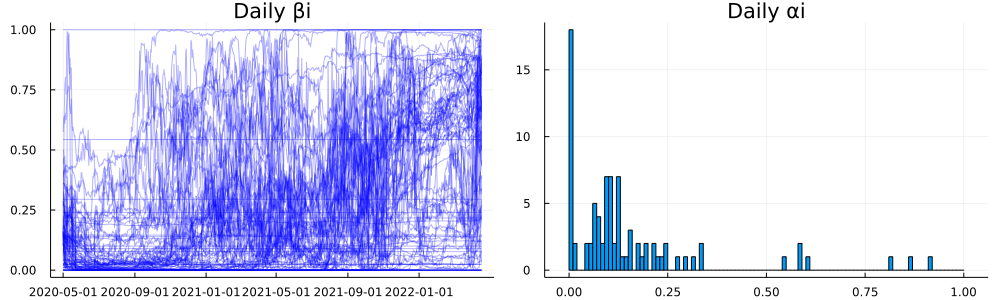

In [75]:
plot(b1, a1, layout = (1, 2), size = (1000, 300))

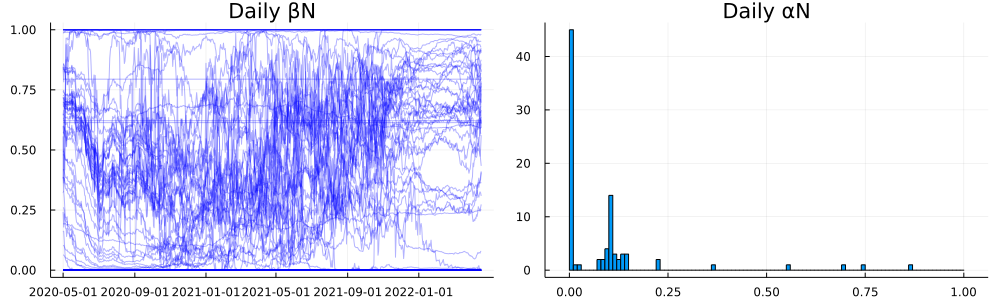

In [76]:
b2 = plot(muni_daily.Date, Matrix(muni1_βN_daily), 
    color = :blue, alpha = 0.3, label = :none,
    title = "Daily βN",
    xticks = collect(muni_daily.Date[1]:Month(4):muni_daily.Date[nrow(muni_daily)]));
a2 = histogram(parse.(Float64, muni1_res_coef_daily.αN), 
    bins = 0:0.01:1, title = "Daily αN", label = :none);
plot(b2, a2, layout = (1, 2), size = (1000, 300))

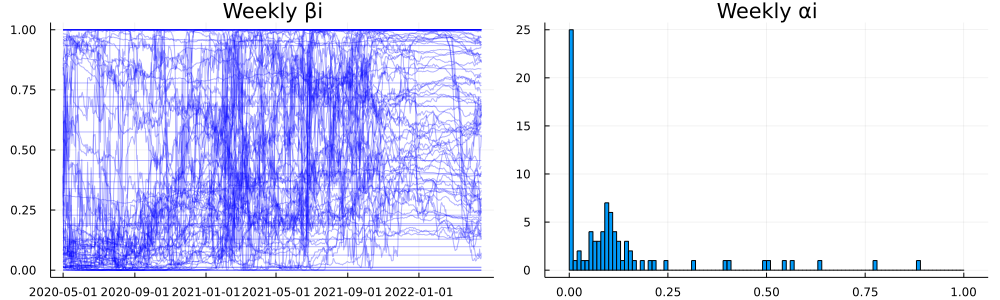

In [77]:
b3 = plot(muni_weekly.Date, Matrix(muni1_βi_weekly), 
    color = :blue, alpha = 0.3, label = :none,
    title = "Weekly βi",
    xticks = collect(muni_weekly.Date[1]:Month(4):muni_weekly.Date[nrow(muni_weekly)]));
a3 = histogram(parse.(Float64, muni1_res_coef_weekly.αi), 
    bins = 0:0.01:1, title = "Weekly αi", label = :none);
plot(b3, a3, layout = (1, 2), size = (1000, 300))

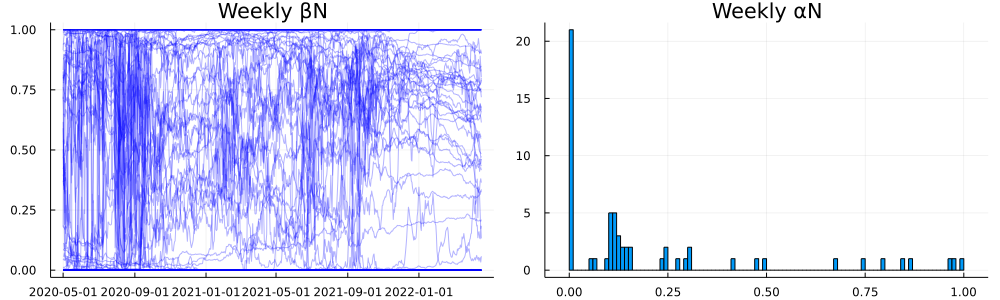

In [78]:
b4 = plot(muni_weekly.Date, Matrix(muni1_βN_weekly), 
    color = :blue, alpha = 0.3, label = :none,
    title = "Weekly βN",
    xticks = collect(muni_weekly.Date[1]:Month(4):muni_weekly.Date[nrow(muni_weekly)]));
a4 = histogram(parse.(Float64, muni1_res_coef_weekly.αN), 
    bins = 0:0.01:1, title = "Weekly αN", label = :none);
plot(b4, a4, layout = (1, 2), size = (1000, 300))

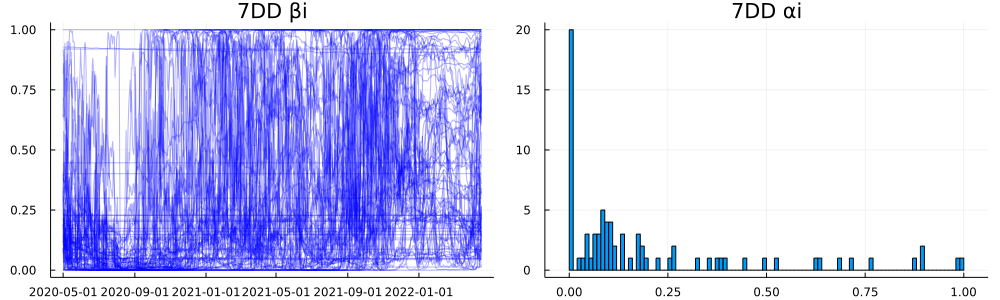

In [79]:
b5 = plot(muni_7dd.Date, Matrix(muni1_βi_7dd), 
    color = :blue, alpha = 0.3, label = :none,
    title = "7DD βi",
    xticks = collect(muni_7dd.Date[1]:Month(4):muni_7dd.Date[nrow(muni_7dd)]));
a5 = histogram(parse.(Float64, muni1_res_coef_7dd.αi), 
    bins = 0:0.01:1, title = "7DD αi", label = :none);
plot(b5, a5, layout = (1, 2), size = (1000, 300))

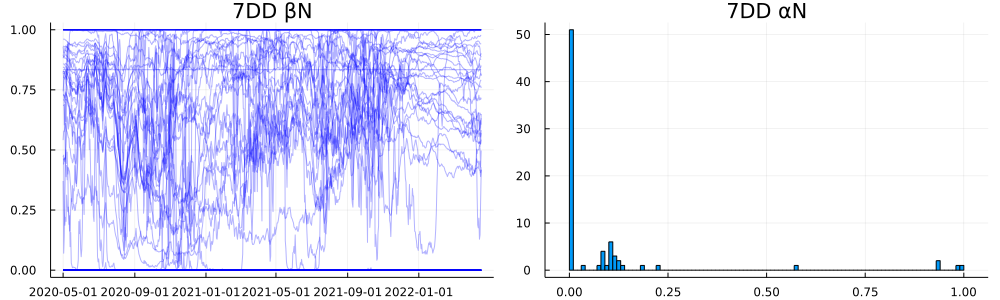

In [80]:
b6 = plot(muni_7dd.Date, Matrix(muni1_βN_7dd), 
    color = :blue, alpha = 0.3, label = :none,
    title = "7DD βN",
    xticks = collect(muni_7dd.Date[1]:Month(4):muni_7dd.Date[nrow(muni_7dd)]));
a6 = histogram(parse.(Float64, muni1_res_coef_7dd.αN), 
    bins = 0:0.01:1, title = "7DD αN", label = :none);
plot(b6, a6, layout = (1, 2), size = (1000, 300))